## Over Sampling Methods comparison

- We will try to compare various over sampling methods with different datasets
- We will be using a random forest model to fit and evaluate the performance based on the Original and Resampled Data

In [1]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

from imblearn.datasets import fetch_datasets
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    SVMSMOTE,
    BorderlineSMOTE
)

In [3]:
# first lets set up a dictionary that contains all the over samplers

oversampler_dict = {
    
    'random' : RandomOverSampler(sampling_strategy='auto',
                                 random_state=0),
    
    'smote' : SMOTE(sampling_strategy='auto',
                    k_neighbors=5,
                    random_state=0,
                    n_jobs=2),
    
    'ada' : ADASYN(sampling_strategy='auto',
                   n_neighbors=5,
                   n_jobs=2,
                   random_state=0),
    
    'bd_smote_1' : BorderlineSMOTE(sampling_strategy='auto',
                                   k_neighbors=5,
                                   m_neighbors=10,
                                   kind='borderline-1',
                                   random_state=0),
    
    'bd_smote_2' : BorderlineSMOTE(sampling_strategy='auto',
                                   k_neighbors=5,
                                   m_neighbors=10,
                                   kind='borderline-2',
                                   random_state=0),
    
    'svm' : SVMSMOTE(sampling_strategy='auto',
                     svm_estimator=SVC(kernel='linear', random_state=0),
                     m_neighbors=10,
                     n_jobs=2,
                     k_neighbors=5,
                     random_state=0)
}

In [4]:
# lets define the datasets in a list
datasets_ls = [
    'car_eval_34',
    'ecoli',
    'thyroid_sick',
    'arrhythmia',
    'ozone_level'
]

In [10]:
# lets get the datasets and see the balance ratio of each one of them

from collections import Counter

for dataset in datasets_ls:
    print(dataset)
    data = fetch_datasets()[dataset]
    print(Counter(data.target))

car_eval_34
Counter({-1: 1594, 1: 134})
ecoli
Counter({-1: 301, 1: 35})
thyroid_sick
Counter({-1: 3541, 1: 231})
arrhythmia
Counter({-1: 427, 1: 25})
ozone_level
Counter({-1: 2463, 1: 73})


## RF Training and evaluation

In [34]:
# lets create a function to run our Model
# this returns the roc auc score of the test data
def run_model(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=39)
    
    # fit the model on the train set
    rf.fit(X_train, y_train)
    
    # get predictions 
    
    train_preds = rf.predict_proba(X_train)[:,1]
    test_preds = rf.predict_proba(X_test)[:,1]
    # get metrics
    print('Training Data roc_auc :  {}'.format(roc_auc_score(y_train, train_preds)))
    print('Test Data roc_auc :  {}'.format(roc_auc_score(y_test, test_preds)))
    print()
    return roc_auc_score(y_test, test_preds)

In [43]:
# for all datasets including the original data
# lets call the function for all over samplers.
# store the results in a dictionary so that we can use to plot them to analyze


# first initialize dictionary to store the results and the size of the resampled or original data
results_dict = dict()
shapes_dict = dict()

for dataset in datasets_ls:
    print(dataset)
    results_dict[dataset] = {}
    shapes_dict[dataset] = {}
    
    data = fetch_datasets()[dataset]
    X = data.data
    y = data.target
    
    # split the data into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=39)
    
    # as some oversampling techniques use KNN
    # we set variables in the same scale
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    #print(X_train.shape, y_train.shape)
    
    results = run_model(X_train, X_test, y_train, y_test)
    results_dict[dataset]['full_data'] = results
    shapes_dict[dataset]['full_data'] = len(X_train)
    
    for sampler in oversampler_dict.keys():
        # fit and resample using the oversampler
        X_res, y_res = oversampler_dict[sampler].fit_resample(X_train, y_train)
        
        print(sampler)
        test_result = run_model(X_res, X_test, y_res, y_test)
        results_dict[dataset][sampler] = test_result
        shapes_dict[dataset][sampler] = len(X_res)
 

car_eval_34
Training Data roc_auc :  0.9910989322498346
Test Data roc_auc :  0.9888888888888889

random
Training Data roc_auc :  0.9972538187069097
Test Data roc_auc :  0.9963675213675214

smote
Training Data roc_auc :  0.9975310154102028
Test Data roc_auc :  0.9939636752136751

ada
Training Data roc_auc :  0.9985749652897028
Test Data roc_auc :  0.995352564102564

bd_smote_1
Training Data roc_auc :  0.9989161931222985
Test Data roc_auc :  0.9959401709401708

bd_smote_2
Training Data roc_auc :  0.9984516469029715
Test Data roc_auc :  0.9958333333333332

svm
Training Data roc_auc :  0.9980265850977764
Test Data roc_auc :  0.9921474358974358

ecoli
Training Data roc_auc :  0.9950312845049688
Test Data roc_auc :  0.9541062801932367

random
Training Data roc_auc :  0.9918728966827682
Test Data roc_auc :  0.9746376811594203

smote
Training Data roc_auc :  0.9896064650534557
Test Data roc_auc :  0.9734299516908214

ada
Training Data roc_auc :  0.9853712140289829
Test Data roc_auc :  0.958937

In [44]:
results_dict, shapes_dict

({'car_eval_34': {'full_data': 0.9888888888888889,
   'random': 0.9963675213675214,
   'smote': 0.9939636752136751,
   'ada': 0.995352564102564,
   'bd_smote_1': 0.9959401709401708,
   'bd_smote_2': 0.9958333333333332,
   'svm': 0.9921474358974358},
  'ecoli': {'full_data': 0.9541062801932367,
   'random': 0.9746376811594203,
   'smote': 0.9734299516908214,
   'ada': 0.9589371980676329,
   'bd_smote_1': 0.9516908212560387,
   'bd_smote_2': 0.9444444444444444,
   'svm': 0.966183574879227},
  'thyroid_sick': {'full_data': 0.9857390213642004,
   'random': 0.9856299507818997,
   'smote': 0.9807354084011617,
   'ada': 0.9829849891611108,
   'bd_smote_1': 0.984573329515863,
   'bd_smote_2': 0.971082661867561,
   'svm': 0.9786767011602383},
  'arrhythmia': {'full_data': 0.832051282051282,
   'random': 0.9243589743589744,
   'smote': 0.8615384615384616,
   'ada': 0.8717948717948719,
   'bd_smote_1': 0.858974358974359,
   'bd_smote_2': 0.905128205128205,
   'svm': 0.841025641025641},
  'ozone_l

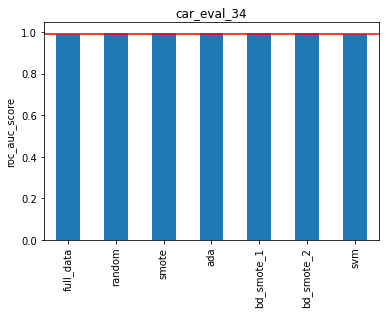

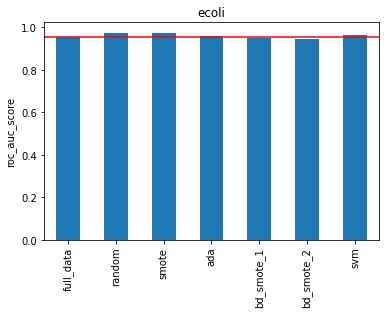

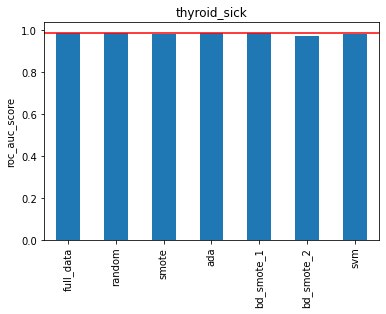

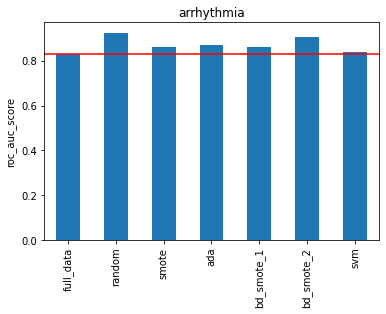

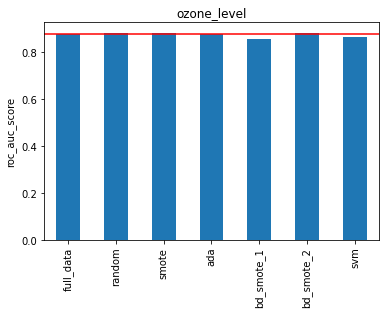

In [48]:
# now lets plot these results_dict using a bar plot

for dataset in datasets_ls:
    pd.Series(results_dict[dataset]).plot.bar()
    
    plt.axhline(results_dict[dataset]['full_data'], c = 'red')
    plt.title(dataset)
    plt.ylabel('roc_auc_score')
    plt.show()

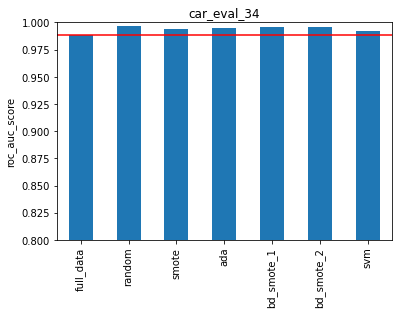

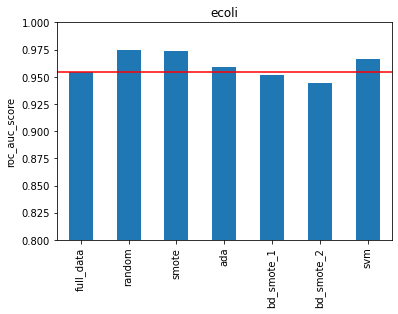

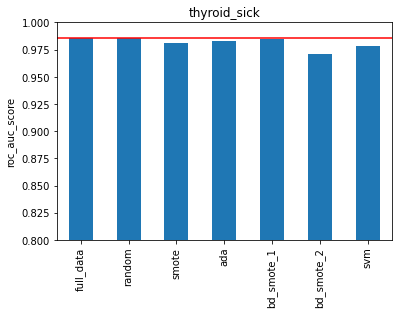

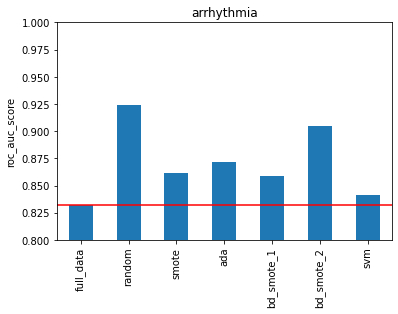

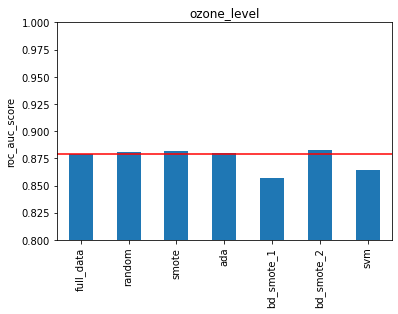

In [49]:
# now lets plot these results_dict using a bar plot
# zooming the ylim value from 0.8 to 1

for dataset in datasets_ls:
    pd.Series(results_dict[dataset]).plot.bar()
    plt.ylim(0.8,1)
    plt.title(dataset)
    plt.ylabel('roc_auc_score')
    plt.axhline(results_dict[dataset]['full_data'], c = 'red')
    plt.show()

**So, we can see that different over sampling techniques work better and different in different datasets**
- So, probably we might need to try few techniques based on the nature of the dataset and will need to find the best one that our model best performs with

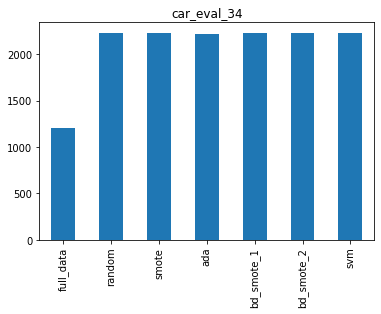

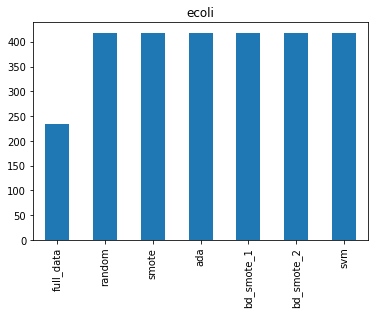

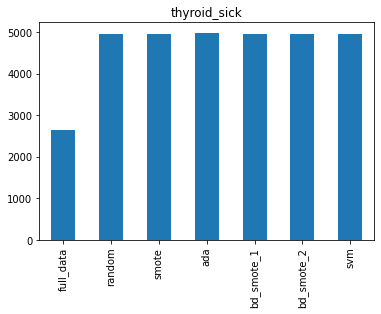

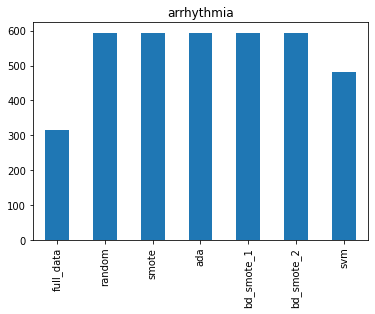

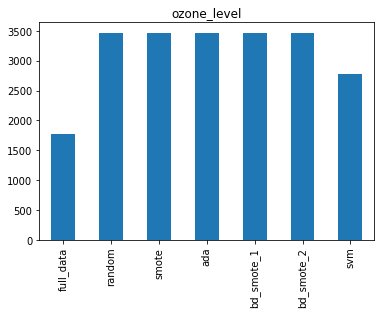

In [47]:
# plotting the shapes

for dataset in datasets_ls:
    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.show()